In [1]:
directory = '/Users/davidkarapetyan/Documents/workspace/data_analysis/'
csv_file = 'data/park345_FL17_SW_air.csv'

import pandas as pd
# for wide terminal display of pandas dataframes
pd.options.display.width = 120
pd.options.display.max_rows = 10000
import numpy as np
import statsmodels.tsa.arima_model as arima
import statsmodels.tsa.statespace.sarimax as sarimax

# plot inline
%pylab inline
# IPython.get_ipython().magic('matplotlib inline')
import matplotlib.pylab as pylab

pylab.rcParams['figure.figsize'] = 14, 6


# load dataframe, and subset out relevant columns
park_data = pd.read_csv(directory + csv_file, error_bad_lines=False)
park_data.columns = ['ID', 'TIMESTAMP',
'TRENDFLAGS', 'STATUS',
'VALUE', 'TRENDFLAGS_TAG',
'STATUS_TAG']
park_data = park_data.sort('TIMESTAMP')


# construct time series, getting rid of microseconds
park_ts = pd.Series(list(park_data.VALUE),
pd.DatetimeIndex(park_data.TIMESTAMP),
name="steam values")

park_ts = park_ts.loc[park_ts != 0].resample('15Min ').interpolate()
print(park_ts)

Populating the interactive namespace from numpy and matplotlib
2013-03-20 02:15:00     66.976562
2013-03-20 02:30:00     66.613251
2013-03-20 02:45:00     66.717041
2013-03-20 03:00:00     66.561340
2013-03-20 03:15:00     66.509460
2013-03-20 03:30:00     66.509460
2013-03-20 03:45:00     66.301880
2013-03-20 04:00:00     66.224030
2013-03-20 04:15:00     66.224030
2013-03-20 04:30:00     65.912659
2013-03-20 04:45:00     65.964569
2013-03-20 05:00:00     65.808868
2013-03-20 05:15:00     65.601257
2013-03-20 05:30:00     65.653168
2013-03-20 05:45:00     67.677155
2013-03-20 06:00:00     69.623291
2013-03-20 06:15:00     69.571411
2013-03-20 06:30:00     69.415710
2013-03-20 06:45:00     70.323914
2013-03-20 07:00:00     70.479614
2013-03-20 07:15:00     70.894806
2013-03-20 07:30:00     72.088440
2013-03-20 07:45:00     72.763123
2013-03-20 08:00:00     73.178284
2013-03-20 08:15:00     73.411804
2013-03-20 08:30:00     73.723175
2013-03-20 08:45:00     73.126373
2013-03-20 09:00:00

In [2]:
print(arima.ARIMA(park_ts, (0, 1, 0)).fit().summary())

                             ARIMA Model Results                              
Dep. Variable:         D.steam values   No. Observations:                34966
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -50324.262
Method:                           css   S.D. of innovations              1.021
Date:                Tue, 07 Jul 2015   AIC                         100652.524
Time:                        13:48:54   BIC                         100669.449
Sample:                    03-20-2013   HQIC                        100657.915
                         - 03-19-2014                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0052      0.005      0.959      0.337        -0.005     0.016


We see that ARIMA is not currently fitting the time series data. We look for
an appropriate transformation of the time series to improve our ARIMA fitting.

###Log Ratio Transformation

To get a properly scaled plot, we filter out the outlier values occuring at
the end of day (shift from some steam usage to none at all as systems
restart, and spikes from ramp-up time at the beginning of the day).

count    34966.000000
mean         0.000038
std          0.008526
min         -0.117525
5%          -0.004286
50%          0.000000
95%          0.003902
max          1.226083
Name: steam values, dtype: float64


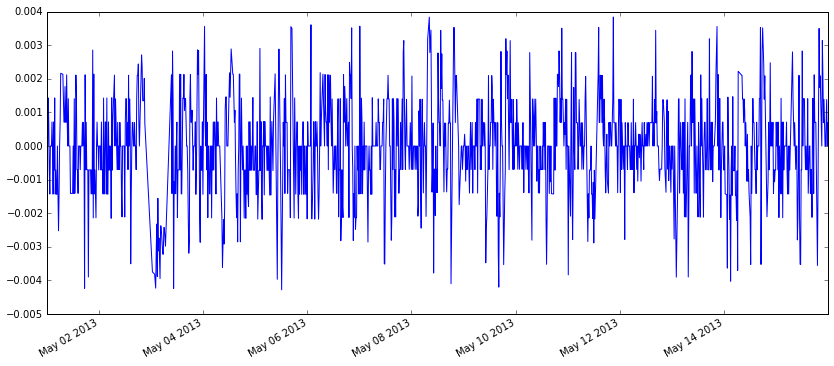

In [65]:
park_ts_logr = (np.log(park_ts / park_ts.shift(1)))[1:]
basic_stats = park_ts_logr.describe(percentiles=[0.05, 0.95])

print(basic_stats)
park_ts_logr[park_ts_logr.between(basic_stats['5%'], 
              basic_stats['95%']
             )]['2013-05-01': '2013-05-15'].plot()

The seasonality is clear. We now plot a single day, filtering out
outliers to get a properly scaled figure.

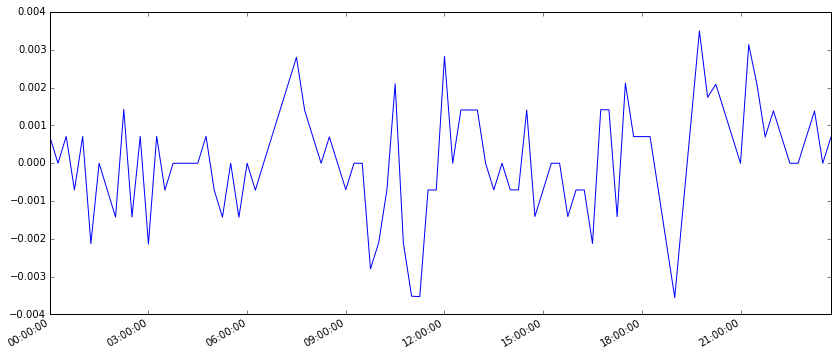

In [68]:
park_ts_logr[park_ts_logr.between(basic_stats['5%'], 
              basic_stats['95%']
             )]['2013-05-15'].plot()

Next, we utilise a SARIMAX model, with seasonality at 96
(our data points are spaced at 15 minute intervals),
and analyze a week's worth of data (starting on Monday, and ending on Friday).

In [5]:
print(sarimax.SARIMAX(park_ts_logr.loc['2013-05-06':'2013-05-10'],
seasonal_order=(0, 1, 0, 96)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                  480
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 96)   Log Likelihood                1663.348
Date:                            Tue, 07 Jul 2015   AIC                          -3322.697
Time:                                    13:48:57   BIC                          -3314.349
Sample:                                05-06-2013   HQIC                         -3319.415
                                     - 05-10-2013                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1          0.0807      0.050      1.603      0.109        -0.018     0.179
sigma2      1.009e-05   7.31e-07     13.816      0.000      8.66e-06  1.15e-05


While the fit isn't terrible, it perhaps can be improved by first observing
that we have spikes in our at the beginning of the day. This is due to
the ratio of consecutive values dipping suddenly at the end of day
as systems are ramped down.
Observe that the only negative values in the data occur at the start of
day. We filter these out, and re-run SARIMA.

In [6]:
print(sarimax.SARIMAX(
park_ts_logr[park_ts_logr > 0]['2013-05-06':'2013-05-10'],
seasonal_order=(0, 1, 0, 95)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                  189
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 95)   Log Likelihood                 420.252
Date:                            Tue, 07 Jul 2015   AIC                           -836.504
Time:                                    13:49:01   BIC                           -830.020
Sample:                                05-06-2013   HQIC                          -833.877
                                     - 05-10-2013                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1          0.2892      0.090      3.230      0.001         0.114     0.465
sigma2       7.64e-06   1.16e-06      6.614      0.000      5.38e-06   9.9e-06


Our data is clustered very close to the mean--i.e, the spikes are very small spikes. Consequently, the positive of filtering them out (i.e. smoothing the data) outweighs the drawback of reducing the number of points to fit. 

Now, let's use a larger input
(beginning on a Monday, and ending on a Friday), and fit another
Sarimax model to our beginning-of-day spike-filtered data.

In [7]:
print(sarimax.SARIMAX(
park_ts_logr[park_ts_logr > 0]['2013-05-06':'2013-06-07'],
seasonal_order=(0, 1, 0, 95)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                 1292
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 95)   Log Likelihood                5342.746
Date:                            Tue, 07 Jul 2015   AIC                         -10681.493
Time:                                    13:49:09   BIC                         -10671.165
Sample:                                05-06-2013   HQIC                        -10677.617
                                     - 06-07-2013                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1          0.3167      0.025     12.594      0.000         0.267     0.366
sigma2      7.772e-06   3.29e-07     23.609      0.000      7.13e-06  8.42e-06


As expected, this is an even better fit than the fit for the week's worth of data.
Lastly, we input three # months worth of data, beginning on a Monday,
and ending on a Friday.

In [8]:
print(sarimax.SARIMAX(park_ts_logr[park_ts_logr > 0]['2013-05-06': '2013-08-08'],
seasonal_order=(0, 1, 0, 95)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                 3901
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 95)   Log Likelihood               16979.952
Date:                            Tue, 07 Jul 2015   AIC                         -33955.904
Time:                                    13:49:23   BIC                         -33943.366
Sample:                                05-06-2013   HQIC                        -33951.454
                                     - 08-08-2013                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1          0.2045      0.015     13.452      0.000         0.175     0.234
sigma2      7.807e-06   1.75e-07     44.651      0.000      7.46e-06  8.15e-06


Let's contrast this with our fit when we include the end-of-day spikes:

In [9]:
print(sarimax.SARIMAX(park_ts_logr['2013-05-06': '2013-08-08'],
seasonal_order=(0, 1, 0, 96)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                 9120
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 96)   Log Likelihood               39525.646
Date:                            Tue, 07 Jul 2015   AIC                         -79047.292
Time:                                    13:50:14   BIC                         -79033.056
Sample:                                05-06-2013   HQIC                        -79042.451
                                     - 08-08-2013                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1          0.2651      0.009     28.081      0.000         0.247     0.284
sigma2      9.181e-06   1.42e-07     64.789      0.000       8.9e-06  9.46e-06


Hence, it makes sense to keep the analysis of
15-minute ramp-up and ramp-down times together with the analysis of the remaining data.

##SARIMAX on Data for Individual Days

We next investigate seasonality on a weekly basis. That is, we
isolate the 5-day workweek into 5 chunks, and run SARIMAX on
each chunk separately.

In [10]:
print(sarimax.SARIMAX(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 0,
park_ts_logr > 0)],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 1,
park_ts_logr > 0)],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 2,
park_ts_logr > 0)],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 3,
park_ts_logr > 0)],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 4,
park_ts_logr > 0)],
seasonal_order=(0, 1, 0, 95)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                 1818
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 95)   Log Likelihood                6446.589
Date:                            Tue, 07 Jul 2015   AIC                         -12889.178
Time:                                    13:50:27   BIC                         -12878.167
Sample:                                03-25-2013   HQIC                        -12885.116
                                     - 02-17-2014                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1          0.4245      0.019     22.825      0.000         0.388     0.461
sigma2      3.294e-05    1.1e-06     30.046      0.000      3.08e-05  3.51e-05
                                 Statespace Mod

/Users/davidkarapetyan/Library/Python/3.4/lib/python/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Including the spikes gives:

In [11]:
print(sarimax.SARIMAX(park_ts_logr[park_ts_logr.index.weekday == 0],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[park_ts_logr.index.weekday == 1],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[park_ts_logr.index.weekday == 2],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[park_ts_logr.index.weekday == 3],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[park_ts_logr.index.weekday == 4],
seasonal_order=(0, 1, 0, 95)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                 4992
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 95)   Log Likelihood               18677.596
Date:                            Tue, 07 Jul 2015   AIC                         -37351.193
Time:                                    13:51:22   BIC                         -37338.161
Sample:                                03-25-2013   HQIC                        -37346.625
                                     - 03-17-2014                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1          0.2231      0.013     16.738      0.000         0.197     0.249
sigma2      2.848e-05   5.96e-07     47.766      0.000      2.73e-05  2.96e-05
                                 Statespace Mod

/Users/davidkarapetyan/Library/Python/3.4/lib/python/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


##ARIMAX For Ramp-up and Ramp-Down

We shall treat Monday ramp-ups separately from the remaining days of the week,
due to difference between system-idling over weekends and weekdays.

In [12]:
print(arima.ARIMA(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 0,
park_ts_logr < 0)],
order=(0, 1, 0)).fit().summary())

                             ARIMA Model Results                              
Dep. Variable:         D.steam values   No. Observations:                 1795
Model:                 ARIMA(0, 1, 0)   Log Likelihood                7314.528
Method:                           css   S.D. of innovations              0.004
Date:                Tue, 07 Jul 2015   AIC                         -14625.057
Time:                        13:52:14   BIC                         -14614.071
Sample:                    03-25-2013   HQIC                        -14621.001
                         - 02-17-2014                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       1.841e-06   9.71e-05      0.019      0.985        -0.000     0.000


Observe that between end of day and start of day, chilled water temperature
decreases, and so $$\frac{T_k(0 + 00:15)}{T_k(0)} = a_k < 1$$ for each
entry in our training set. The set $\{a_k\}_k$ will hopefully consist of
entries that are clustered near one another, with some reasonable volatility.
Taking a logarithm of them will result in an exponential increase in
volatility, since $log(x)$ is an exponential function of $x$ for decreasing
$x < 1$. This will result in decreasing the goodness-of-fit of a linear
model, from a least-squares standpoint. Consequently, we exponentiate our
time series data, and re-fit:

In [13]:
print(arima.ARIMA(np.exp(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 0,
park_ts_logr < 0)]),
order=(0, 1, 0)).fit().summary())

                             ARIMA Model Results                              
Dep. Variable:         D.steam values   No. Observations:                 1795
Model:                 ARIMA(0, 1, 0)   Log Likelihood                7342.702
Method:                           css   S.D. of innovations              0.004
Date:                Tue, 07 Jul 2015   AIC                         -14681.405
Time:                        13:52:14   BIC                         -14670.419
Sample:                    03-25-2013   HQIC                        -14677.349
                         - 02-17-2014                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        1.83e-06   9.55e-05      0.019      0.985        -0.000     0.000


Observe that the fit has improved, though not dramatically like for some of our other time series. This is due to Monday ramp-up values being very close to the mean. In general, our time series values are clustered very close together throughout the week. 